In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']=".97"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
#import pyccl as ccl
import pickle as pk

%load_ext autoreload
%autoreload 2






/tmp/ipykernel_545002/1187361990.py:9: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.1
sim_params_dict['log10_Mstar0_theta_co'] = 15.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 15.0
sim_params_dict['nu_theta_ej_M'] =0.0
sim_params_dict['nu_theta_ej_z'] = 0.05

sim_params_dict['log10_Mc0'] = 15.0
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = -2.5
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 24, 256
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 3.0, 24
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 10.0, 16.0, 64
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 3, 7, 24
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 5
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits')
theta_data = df_data['xip'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
# analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 128
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.0
analysis_dict['want_like_diff'] = True
analysis_dict['calc_nfw_only'] = True

other_params_dict = {}
other_params_dict['A_IA'] = 0.1
other_params_dict['eta_IA'] = 0.0
other_params_dict['z0_IA'] = 0.62
other_params_dict['C1_bar'] = 5e-14
# for jb in range(nz_info_dict['nbins']):
#     other_params_dict['Delta_z_bias_bin%d'%(jb+1)] = 0.0
#     other_params_dict['mult_shear_bias_bin%d'%(jb+1)] = 0.0
other_params_dict['Delta_z_bias_array'] = jnp.zeros(nz_info_dict['nbins'])
other_params_dict['mult_shear_bias_array'] = jnp.zeros(nz_info_dict['nbins'])



In [3]:
h = sim_params_dict['cosmo']['H0'] / 100.0
Ob = sim_params_dict['cosmo']['Ob0']
Om = sim_params_dict['cosmo']['Om0']
import astropy.units as u
from astropy import constants as const
import jax_cosmo.background as bkgrd
import scipy.integrate as integrate
from setup_power_spectra_jit import setup_power_BCMP
sigmat = const.sigma_T
m_e = const.m_e
c = const.c
coeff = sigmat / (m_e * (c ** 2))
oneMpc_h_to_cm = (((10 ** 6)/h) * (u.pc).to(u.cm))
const_coeff = ((coeff).to(((u.kpc ** 2) / u.keV))).value



In [4]:
import copy
from get_BCMP_profile_jit import BCM_18_wP
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import scipy.integrate as integrate

# BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)

setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict, num_points_trapz_int=64)

Pk_sup_mean = setup_power_BCMP_test.Pmm_sup_tot_mat
k_sup_mean = setup_power_BCMP_test.k
# Pk_sup2 = (setup_power_BCMP_test.plin_kz_mat +  setup_power_BCMP_test.Pmm_dmb_1h_mat)/(setup_power_BCMP_test.plin_kz_mat +  setup_power_BCMP_test.Pmm_nfw_1h_mat)

# k1 = 0.4
# k2 = 0.7
# k3 = 1.0
# k4 = 2.0

# indk1 = jnp.argmin(jnp.abs(k_sup - k1))
# indk2 = jnp.argmin(jnp.abs(k_sup - k2))
# indk3 = jnp.argmin(jnp.abs(k_sup - k3))
# indk4 = jnp.argmin(jnp.abs(k_sup - k4))

# M_test_noh = 1e14
# M_test = M_test_noh * h



In [5]:
z_test = 0.0   
z_array = setup_power_BCMP_test.z_array   
indz = np.argmin(np.abs(z_array - z_test))


In [6]:
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)



M_array = setup_power_BCMP_test.M_array
z_array = setup_power_BCMP_test.z_array
c_array = setup_power_BCMP_test.conc_array
# indz = np.argmin(np.abs(z_array - z_test))
Y_int_j_all_mean = np.zeros(len(M_array))
Y_SS_all_mean = np.zeros(len(M_array))
from tqdm import tqdm
for jM in tqdm(range(len(M_array))):
    M_test = M_array[jM]

    indM = np.argmin(np.abs(np.log10(M_array) - np.log10(M_test)))
    # indc = 
    c_test = setup_power_BCMP_test.conc_Mz_mat[indz, indM]
    indc = np.argmin(np.abs(c_array - c_test))


    r200c_Mz = BCMP_test.r200c_mat[indM, indz]
    indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
    r_array_j = BCMP_test.r_array[indsel_r]

    # rho_cga_j = BCMP_test.rho_cga_mat[indsel_r,indc, indz, indM]
    # rho_clm_j = BCMP_test.rho_clm_mat[indsel_r,indc, indz, indM]
    # rho_gas_j = BCMP_test.rho_gas_mat[indsel_r,indc, indz, indM]
    # rho_dmb_j = BCMP_test.rho_dmb_mat[indsel_r,indc, indz, indM]
    # rho_nfw_j = BCMP_test.rho_nfw_mat[indsel_r,indc, indz, indM]
    Pe_mat_j = BCMP_test.Pe_mat_physical[indsel_r,indc, indz, indM]

    # Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
    # Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
    # Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
    # Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
    # Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
    Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
    Y_int_j = const_coeff * Pe_int_j

    Ez = np.sqrt(bkgrd.growth_factor(setup_power_BCMP_test.cosmo_jax, setup_power_BCMP_test.scale_fac_a_array))[indz]
    M200_noh = M_array[indM]/h
    h70 = h/0.7
    Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)

    Y_int_j_all_mean[jM] = Y_int_j
    Y_SS_all_mean[jM] = Y_ss

    


100%|██████████| 64/64 [00:39<00:00,  1.62it/s]


In [7]:
# # sims_params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta','nu_theta_ej_M','eta_star','alpha_nt']
# param_vary_name = 'mu_beta'
# param_vary_array = np.linspace(0.0, 0.5, 5)

# # param_vary_name = 'nu_theta_ej_M'
# # param_vary_array = np.linspace(-1.5, 1.0, 8)

# import copy
# from get_BCMP_profile_jit import BCM_18_wP
# from setup_power_spectra_jit import setup_power_BCMP
# from tqdm import tqdm
# import scipy.integrate as integrate

# Y_YSS_all_samps_Y1 = np.zeros((len(param_vary_array), len(M_array)))
# Pk_sup_all_samps_Y1 = np.zeros((len(param_vary_array), len(k_sup_mean)))

# for jsim in tqdm(range((len(param_vary_array)))):

#     sim_params_dict_vary = copy.deepcopy(sim_params_dict)

#     # for jp in range(len(cosmo_params_vary_names)):
#     #     sim_params_dict_vary['cosmo'][cosmo_params_vary_names[jp]] = samples_Y6_sel[jsim, jp]

#     # h = sim_params_dict_vary['cosmo']['H0'] / 100.0
#     # Om = sim_params_dict_vary['cosmo']['Om0']
#     # Ob = sim_params_dict_vary['cosmo']['Ob0']

#     # for jp in range(len(sims_params_vary_names)):
#         # sim_params_dict_vary[sims_params_vary_names[jp]] = samples_Y6_sel[jsim, jp + len(cosmo_params_vary_names)]
#     sim_params_dict_vary[param_vary_name] = param_vary_array[jsim]

#     halo_params_dict_vary = copy.deepcopy(halo_params_dict)
#     halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 11.0, 15.5, 64

#     BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

#     setup_power_BCMP_test = setup_power_BCMP(sim_params_dict_vary, halo_params_dict_vary, analysis_dict, num_points_trapz_int=64)


#     Pk_sup_jsim = setup_power_BCMP_test.Pmm_sup_tot_mat
#     k_sup_jsim = setup_power_BCMP_test.k

#     M_array = setup_power_BCMP_test.M_array
#     z_array = setup_power_BCMP_test.z_array
#     c_array = setup_power_BCMP_test.conc_array
#     Y_int_j_all_jsim = np.zeros(len(M_array))
#     Y_SS_all_jsim = np.zeros(len(M_array))
#     from tqdm import tqdm
#     for jM in tqdm(range(len(M_array))):
#         M_test = M_array[jM]

#         indM = np.argmin(np.abs(np.log10(M_array) - np.log10(M_test)))
#         # indc = 
#         c_test = setup_power_BCMP_test.conc_Mz_mat[indz, indM]
#         indc = np.argmin(np.abs(c_array - c_test))


#         r200c_Mz = BCMP_test.r200c_mat[indM, indz]
#         indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
#         r_array_j = BCMP_test.r_array[indsel_r]

#         Pe_mat_j = BCMP_test.Pe_mat_physical[indsel_r,indc, indz, indM]

#         Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
#         Y_int_j = const_coeff * Pe_int_j

#         Ez = np.sqrt(bkgrd.growth_factor(setup_power_BCMP_test.cosmo_jax, setup_power_BCMP_test.scale_fac_a_array))[indz]
#         M200_noh = M_array[indM]/h
#         h70 = h/0.7
#         Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)

#         Y_int_j_all_jsim[jM] = Y_int_j
#         Y_SS_all_jsim[jM] = Y_ss

        
#     Y_YSS_all_samps_Y1[jsim,:] = Y_int_j_all_jsim/Y_SS_all_jsim
#     Pk_sup_all_samps_Y1[jsim,:] = Pk_sup_jsim[:,indz]






In [8]:
# pl.figure()
# pl.plot((M_array), (Y_int_j_all_mean/Y_SS_all_mean))
# for jsim in range(len(param_vary_array)):
#     pl.plot((M_array), Y_YSS_all_samps_Y1[jsim,:], alpha=0.5, label=r'$\mu_{\beta} = %.2f$'%(param_vary_array[jsim]))
# pl.legend()
# # pl.plot((M_array), Y_YSS_all_samps_Y1[20,:], alpha=0.5)
# pl.xscale('log')
# pl.yscale('log')
# pl.xlim(1e12, 5e15)
# pl.ylim(1e-2, 10.0)






In [9]:
# samples_Y1 = np.load('/mnt/home/spandey/ceph/GODMAX/data/DES_Y1_3x2pt_chain.npy')
import pickle as pk
samples_Y1 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_REDUCEDSET.pk', 'rb'))['samples']
samples_Y6 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_REDUCEDSET.pk', 'rb'))['samples']
# samples_Y6 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6.pk', 'rb'))['samples']




In [10]:
nsamp_sel = 50
samples_Y1_sel = samples_Y1[0:nsamp_sel,:]
samples_Y6_sel = samples_Y6[0:nsamp_sel,:]



In [11]:
cosmo_params_vary_names = ['Om0', 'Ob0', 'H0', 'ns', 'sigma8']
# sims_params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta','nu_theta_ej_M','eta_star','alpha_nt']
sims_params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt']



In [12]:
import copy
from get_BCMP_profile_jit import BCM_18_wP
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import scipy.integrate as integrate

Y_YSS_all_samps_Y1 = np.zeros((len(samples_Y1_sel), len(M_array)))
Pk_sup_all_samps_Y1 = np.zeros((len(samples_Y1_sel), len(k_sup_mean)))

for jsim in tqdm(range((nsamp_sel))):

    sim_params_dict_vary = copy.deepcopy(sim_params_dict)

    for jp in range(len(cosmo_params_vary_names)):
        # sim_params_dict_vary['cosmo'][cosmo_params_vary_names[jp]] = samples_Y6_sel[jsim, jp]
        sim_params_dict_vary['cosmo'][cosmo_params_vary_names[jp]] = samples_Y1_sel[jsim, jp]        

    h = sim_params_dict_vary['cosmo']['H0'] / 100.0
    Om = sim_params_dict_vary['cosmo']['Om0']
    Ob = sim_params_dict_vary['cosmo']['Ob0']

    for jp in range(len(sims_params_vary_names)):
        # sim_params_dict_vary[sims_params_vary_names[jp]] = samples_Y6_sel[jsim, jp + len(cosmo_params_vary_names)]
        sim_params_dict_vary[sims_params_vary_names[jp]] = samples_Y1_sel[jsim, jp + len(cosmo_params_vary_names)]        


    halo_params_dict_vary = copy.deepcopy(halo_params_dict)
    halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 11.0, 15.5, 64

    BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

    setup_power_BCMP_test = setup_power_BCMP(sim_params_dict_vary, halo_params_dict_vary, analysis_dict, num_points_trapz_int=64)


    Pk_sup_jsim = setup_power_BCMP_test.Pmm_sup_tot_mat
    k_sup_jsim = setup_power_BCMP_test.k

    M_array = setup_power_BCMP_test.M_array
    z_array = setup_power_BCMP_test.z_array
    c_array = setup_power_BCMP_test.conc_array
    Y_int_j_all_jsim = np.zeros(len(M_array))
    Y_SS_all_jsim = np.zeros(len(M_array))
    from tqdm import tqdm
    for jM in tqdm(range(len(M_array))):
        M_test = M_array[jM]

        indM = np.argmin(np.abs(np.log10(M_array) - np.log10(M_test)))
        # indc = 
        c_test = setup_power_BCMP_test.conc_Mz_mat[indz, indM]
        indc = np.argmin(np.abs(c_array - c_test))


        r200c_Mz = BCMP_test.r200c_mat[indM, indz]
        indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
        r_array_j = BCMP_test.r_array[indsel_r]

        Pe_mat_j = BCMP_test.Pe_mat_physical[indsel_r,indc, indz, indM]

        Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
        Y_int_j = const_coeff * Pe_int_j

        Ez = np.sqrt(bkgrd.growth_factor(setup_power_BCMP_test.cosmo_jax, setup_power_BCMP_test.scale_fac_a_array))[indz]
        M200_noh = M_array[indM]/h
        h70 = h/0.7
        Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)

        Y_int_j_all_jsim[jM] = Y_int_j
        Y_SS_all_jsim[jM] = Y_ss

        
    Y_YSS_all_samps_Y1[jsim,:] = Y_int_j_all_jsim/Y_SS_all_jsim
    Pk_sup_all_samps_Y1[jsim,:] = Pk_sup_jsim[:,indz]





  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [12:48<06:28, 22.84s/it]2024-01-07 04:00:13.486526: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.81GiB (rounded to 3020181504)requested by op 
2024-01-07 04:00:13.488346: W external/tsl/tsl/framework/bfc_allocator.cc:497] *********************************________________***************************************************
2024-01-07 04:00:13.488523: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3020181280 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:     2.7KiB
              constant allocation:    84.2KiB
        maybe_live_out allocation:    9.00MiB
     preallocated temp allocation:    2.81GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    2.82GiB
              total fragmentation:    8.99MiB (0.3

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3020181280 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:     2.7KiB
              constant allocation:    84.2KiB
        maybe_live_out allocation:    9.00MiB
     preallocated temp allocation:    2.81GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    2.82GiB
              total fragmentation:    8.99MiB (0.31%)
Peak buffers:
	Buffer 1:
		Size: 768.00MiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/exp" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=366
		XLA Label: fusion
		Shape: f64[32,64,3,256,64]
		==========================

	Buffer 2:
		Size: 768.00MiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/exp" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=366
		XLA Label: fusion
		Shape: f64[1,32,64,3,256,64]
		==========================

	Buffer 3:
		Size: 768.00MiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/exp" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=366
		XLA Label: fusion
		Shape: f64[1,32,64,3,256,64]
		==========================

	Buffer 4:
		Size: 288.00MiB
		XLA Label: fusion
		Shape: f64[32,64,3,24,256]
		==========================

	Buffer 5:
		Size: 288.00MiB
		XLA Label: fusion
		Shape: f64[32,64,3,24,256]
		==========================

	Buffer 6:
		Size: 9.00MiB
		Operator: op_name="jit(get_zeta)/jit(main)/jit(_interp)/jit(_where)/select_n" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=469
		XLA Label: fusion
		Shape: f64[64,3,24,256]
		==========================

	Buffer 7:
		Size: 64.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=466
		XLA Label: fusion
		Shape: f64[32,256]
		==========================

	Buffer 8:
		Size: 64.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/div" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=466
		XLA Label: fusion
		Shape: f64[32,256]
		==========================

	Buffer 9:
		Size: 36.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(3, 4, 5), collapsed_slice_dims=(), start_index_map=(0, 1, 2)) slice_sizes=(1, 1, 1) unique_indices=False indices_are_sorted=False mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=366
		XLA Label: fusion
		Shape: f64[4608,1,1,1]
		==========================

	Buffer 10:
		Size: 36.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(3, 4, 5), collapsed_slice_dims=(), start_index_map=(0, 1, 2)) slice_sizes=(1, 1, 1) unique_indices=False indices_are_sorted=False mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=366
		XLA Label: fusion
		Shape: f64[4608,1,1,1]
		==========================

	Buffer 11:
		Size: 36.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(3, 4, 5), collapsed_slice_dims=(), start_index_map=(0, 1, 2)) slice_sizes=(1, 1, 1) unique_indices=False indices_are_sorted=False mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=366
		XLA Label: fusion
		Shape: f64[64,3,24]
		==========================

	Buffer 12:
		Size: 36.0KiB
		Operator: op_name="jit(get_zeta)/jit(main)/vmap(jit(get_Mcga))/vmap(jit(get_rho_cga))/gather[dimension_numbers=GatherDimensionNumbers(offset_dims=(3, 4, 5), collapsed_slice_dims=(), start_index_map=(0, 1, 2)) slice_sizes=(1, 1, 1) unique_indices=False indices_are_sorted=False mode=GatherScatterMode.PROMISE_IN_BOUNDS fill_value=None]" source_file="/mnt/ceph/users/spandey/GODMAX/src/get_BCMP_profile_jit.py" source_line=366
		XLA Label: fusion
		Shape: f64[4608,1,1,1]
		==========================

	Buffer 13:
		Size: 36.0KiB
		XLA Label: constant
		Shape: f64[24,3,64]
		==========================

	Buffer 14:
		Size: 36.0KiB
		XLA Label: constant
		Shape: f64[24,3,64]
		==========================

	Buffer 15:
		Size: 2.0KiB
		Entry Parameter Subshape: s64[256]
		==========================



In [ ]:
saved = {'k_sup_jsim':k_sup_jsim, 'M_array':M_array, 'Y_YSS_all_samps_Y1':Y_YSS_all_samps_Y1, 'Pk_sup_all_samps_Y1':Pk_sup_all_samps_Y1}
pk.dump(saved, open('/mnt/home/spandey/ceph/GODMAX/data/forecast/forecast_Y_YSS_Pk_LSST_Y1_REDUCEDSET.pk', 'wb'))




(0.05, 10.0)

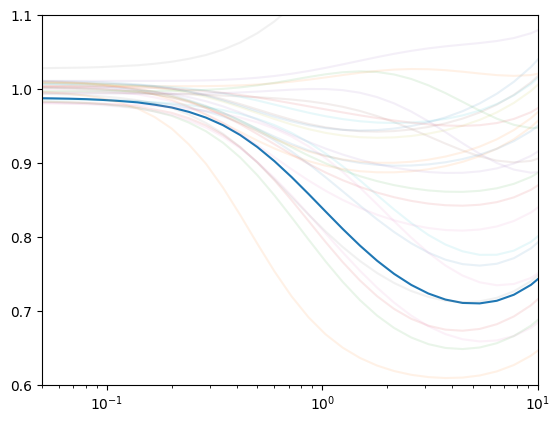

In [13]:
pl.figure()
pl.plot(k_sup_mean, Pk_sup_mean[:,indz])
for jsim in range(nsamp_sel):
    pl.plot(k_sup_jsim, Pk_sup_all_samps_Y1[jsim,:], alpha=0.1)
# pl.plot(k_sup, Pk_sup2[:,indz])
pl.xscale('log')
pl.ylim(0.6, 1.1)
# pl.ylim(0.95, 1.05)
pl.xlim(5e-2, 1e1)




(0.01, 1.5)

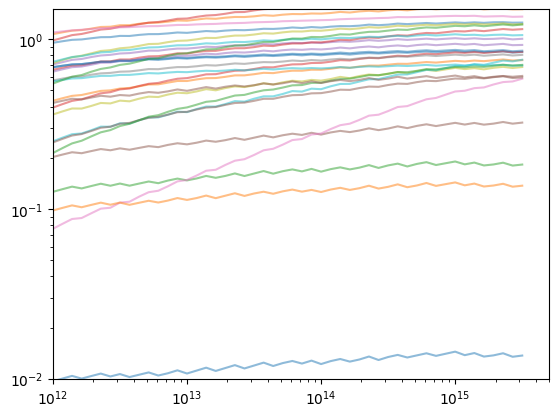

In [16]:
pl.figure()
# pl.plot((M_array), (Y_int_j_all_mean/Y_SS_all_mean))
for jsim in range(nsamp_sel):
    pl.plot((M_array), Y_YSS_all_samps_Y1[jsim,:], alpha=0.5)

# pl.plot((M_array), Y_YSS_all_samps_Y1[20,:], alpha=0.5)
pl.xscale('log')
pl.yscale('log')
pl.xlim(1e12, 5e15)
pl.ylim(1e-2, 1.5)




In [51]:
# 2, 3, 6, 10, 12, 13

samples_Y1_sel[2,5:13]



array([ 4.79694249,  0.10195987, -2.32668504,  2.0157027 , -0.09266582,
        0.78890775,  0.35647759,  1.39528265])

In [52]:
samples_Y1_sel[0,5:13]


array([ 4.32561742,  0.10007053, -2.05322292,  2.312538  ,  0.24471433,
       -0.20071446,  0.2826226 ,  0.13273525])